In [19]:
import numpy as np
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import types

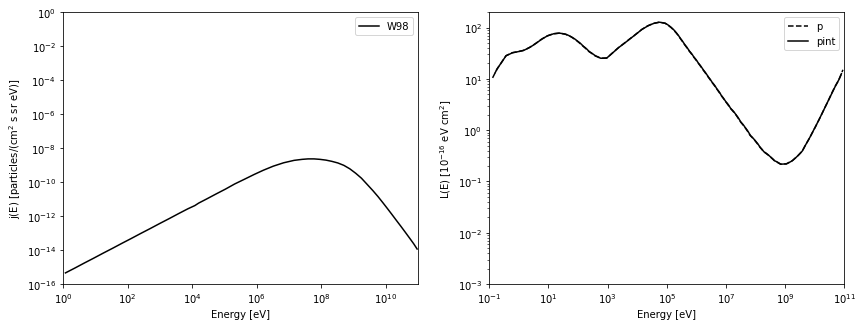

In [2]:
# Load proton spectra from Padovani (and others)
file_W98 = "data/W98.csv"

w98 = types.SimpleNamespace()
w98.energy, w98.spectrum = np.loadtxt(file_W98, delimiter=',', comments='#', unpack=True)

# Load Energy loss function L(E) from Padovani
file_protons = "data/energyLoss_protons.csv"
pLoss = types.SimpleNamespace()
pLoss.E, pLoss.L = np.loadtxt(file_protons, delimiter=',', comments='#', unpack=True)

pLoss.Einterp = np.logspace(-0.8, 10.9, num=2000, endpoint=True)
fint_LE = scipy.interpolate.interp1d(pLoss.E, pLoss.L, kind='linear', assume_sorted=True)
pLoss.Linterp = fint_LE(pLoss.Einterp)

fig, axs = plt.subplots(1,2, figsize=(14,5))
axs[0].loglog(w98.energy, w98.spectrum, 'k-', label="W98")
axs[0].set_xlim(1,1e11)
axs[0].set_ylim(1e-16,1)
axs[0].set_xlabel("Energy [eV]")
axs[0].set_ylabel("j(E) [particles/(cm$^2$ s sr eV)]")
axs[0].legend()

axs[1].loglog(pLoss.E, pLoss.L, 'k--', label="p")
axs[1].loglog(pLoss.Einterp, pLoss.Linterp, 'k-', label="pint")
axs[1].set_xlabel("Energy [eV]")
axs[1].set_ylabel("L(E) [10$^{-16}$ eV cm$^2$]")
axs[1].set_xlim(1e-1,1e11)
axs[1].set_ylim(1e-3,2e2)
axs[1].legend()
fout = 'out/spectraAndEnergyLossFunctions.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

In [4]:
# Compute the range of a particle (proton) given an energy loss function
# by integrating the energy loss function until the particle is at rest.
def rangeOfE(EE, dEdN):
    # Einit: initial particle energy [eV]
    # dEdN: energy loss function (1e-16 eV cm2)
    # EE: corresponding energies for dEdN (eV)
    dE = EE[1:]-EE[:-1]

    ranges = []
    #nn = len(dEdN)-1
    nn = len(dE)
    
    integrand = dE/dEdN[1:]
    for ii in range(nn):
        ranges.append(np.sum(integrand[0:ii]))

    return ranges

nn, min, max of pLoss.Einterp: 2000, 0.15848931924611134, 79432823472.42822


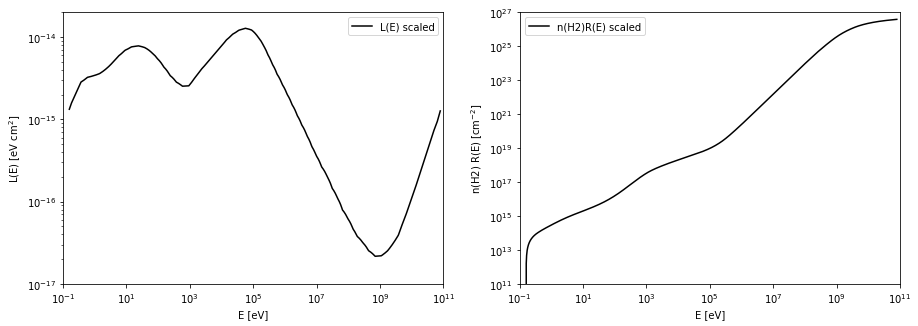

In [7]:
# Follow procedure in Padovani to find j(E,N) from j(E0,0)

# Vary E and E0 from 0.1eV to 100 GeV, determine column density from the difference betwen R(E0) and R(E)
# N(H2) ~ R(E0)-R(E) (see Padovani Equation 21)
# Make contour plot of N(H2) vs. E0 and E
# Pick a single contour (a fixed value of N(H2)) and fit E0 = (cE^b + N/N0)^(1/b)
#.   this tells us what the starting energy E0 is for a given ending energy E
# Once you know the E0 <--> E mapping, you can compute j(E,N) from j(E0,0) and L(E0)/L(E)

print(f'nn, min, max of pLoss.Einterp: {len(pLoss.Einterp)}, {min(pLoss.Einterp)}, {max(pLoss.Einterp)}')

RR = rangeOfE(pLoss.Einterp, pLoss.Linterp)  
# units of pLoss.Linterp are 1e-16 eV cm^2, so "range" is really n(H2)*R(E) and has units of 1e16 cm^{-2}

# convert Linterp to units of eV cm^2
pLossScaled = types.SimpleNamespace()
pLossScaled.E = pLoss.Einterp[:]
pLossScaled.L = pLoss.Linterp[:]*1e-16
RRscaled = rangeOfE(pLossScaled.E, pLossScaled.L)  


# Compute level contours of N(H2)/n(H2) =  R(E0)-R(E)
E0s, EEs = np.meshgrid(pLossScaled.E[1:], pLossScaled.E[1:])
R0s, REs = np.meshgrid(RRscaled, RRscaled)
NNs = R0s-REs

figN, axN = plt.subplots(1, 2, figsize=(15,5))
axN[0].loglog(pLossScaled.E, pLossScaled.L, 'k-', label='L(E) scaled')
axN[0].set_xlim(1e-1, 1e11)
axN[0].set_ylim(1e-17, 2e-14)
axN[0].set_xlabel("E [eV]")
axN[0].set_ylabel("L(E) [eV cm$^2$]")
axN[0].legend()

axN[1].loglog(pLossScaled.E[1:], RRscaled, 'k-', label='n(H2)R(E) scaled')
axN[1].set_xlim(1e-1, 1e11)
axN[1].set_ylim(1e11, 1e27)
axN[1].set_xlabel("E [eV]")
axN[1].set_ylabel("n(H2) R(E) [cm$^{-2}$]")
axN[1].legend()

fout = 'out/energyLossAndRangePadovani.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

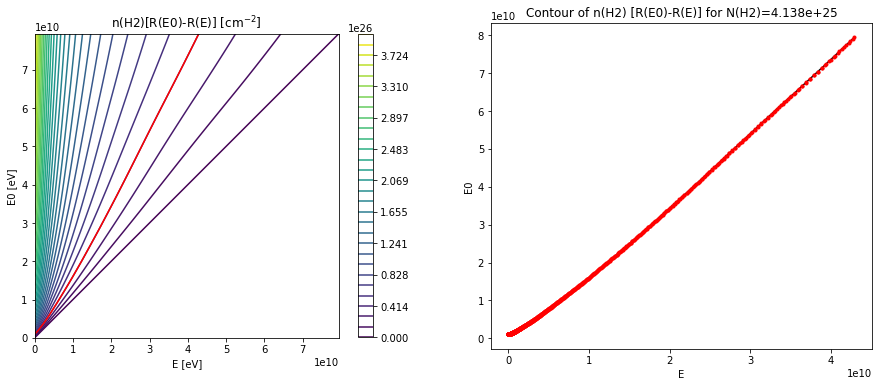

In [34]:
# VISUALIZE N(H2) CONTOURS
fig4, axs4 = plt.subplots(1, 2, figsize=(15,6))
levelMax = 4e26
levels = np.linspace(0, levelMax, num=30, endpoint=True)
#levels = np.logspace(19, 26, num=8, endpoint=True)
#levels = np.logspace(21, 25, num=5, endpoint=True)
cs = axs4[0].contour(EEs, E0s, NNs, levels=levels)#, locator=ticker.LogLocator())#, cmap=cm.PuBu_r)
axs4[0].axis('scaled')
axs4[0].set_xlabel("E [eV]")
axs4[0].set_ylabel("E0 [eV]")
axs4[0].set_title("n(H2)[R(E0)-R(E)] [cm$^{-2}$]")
fig4.colorbar(cs, ax=axs4[0], shrink=0.93)
#axs4[0].clabel(cs, cs.levels, inline=True, fmt="%.2e", fontsize=10)

# pick out a single contour
levelId = 3
NH2s = levels[levelId]
dat0 = cs.allsegs[levelId][0]
xEs  = dat0[:,0]
yE0s = dat0[:,1]

axs4[0].plot(xEs, yE0s, 'r-') # overplot on contour graph
axs4[1].plot(xEs, yE0s, 'k-')
axs4[1].plot(xEs, yE0s, 'r.')
axs4[1].set_xlabel("E")
axs4[1].set_ylabel("E0")
axs4[1].set_title(f"Contour of n(H2) [R(E0)-R(E)] for N(H2)={NH2s:.3e}")

fout = 'out/NH2Contours.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

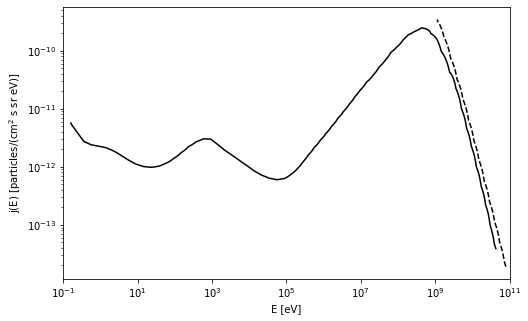

In [45]:
# interpolate L(E) onto our E0 and E values
fint_LE = scipy.interpolate.interp1d(pLoss.E, pLoss.L, kind='linear', assume_sorted=True) # FIXME: this is a repeat from above...
LE_E0 = fint_LE(yE0s)
LE_E  = fint_LE(xEs)

# interpolate j(E0,0) onto our E0 values
fint_w98 = scipy.interpolate.interp1d(w98.energy, w98.spectrum, kind='linear', assume_sorted=True) 
jjw98 = fint_w98(yE0s)

nE = len(yE0s)
jjDegraded = []
for ii in range(nE):
    Ei = xEs[ii]
    E0i = yE0s[ii]
    jjDegraded.append( fint_w98(E0i)*fint_LE(E0i)/fint_LE(Ei) )
    
jjDegraded = np.array(jjDegraded)


fig9, axs9 = plt.subplots(1, 1, figsize=(8,5))
axs9.loglog(yE0s, jjw98, 'k--', label='W98 input spectrum')
axs9.loglog(xEs, jjDegraded, 'k-', label=f'Degraded spectrum (N(H2) = {})')
axs9.set_xlim(1e-1, 1e11)
axs9.set_xlabel("E [eV]")
axs9.set_ylabel("j(E) [particles/(cm$^2$ s sr eV)]")
fout = 'out/spectrumOriginalAndDegraded.pdf'
plt.savefig(fout)
plt.savefig(fout.replace(".pdf",".png"))

# fig9, axs9 = plt.subplots(1, 2, figsize=(15,5))
# axs9[0].loglog(pLossScaled.E, pLossScaled.L, 'k-')
# axs9[0].set_xlim(1e-1, 1e11)
# axs9[0].set_ylim(1e-19, 2e-14)
# axs9[0].set_xlabel("E [eV]")
# axs9[0].set_ylabel("L(E) [eV cm$^2$]")

# axs9[1].loglog(yE0s, jjw98, 'k--')
# axs9[1].loglog(xEs, jjDegraded, 'k-')
# axs9[1].set_xlim(1e-1, 1e11)
# axs9[1].set_xlabel("E [eV]")
# axs9[1].set_ylabel("j(E) [particles/(cm$^2$ s sr eV)]")
    